# Herman Franclin Tesso Tassang

# Applied Machine Learning at scale : Variational Bayes Approach

In [ ]:
#@title dependencies
import pandas as pd
import numpy as np
import math
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pickle
import random

In [ ]:
#@title Upload data from my drive
import gdown
# ratings file
url = 'https://drive.google.com/uc?id=1y0AA7ZCNOWLY1-FNvaQdzmqZAckxHZSq'
output = 'ratings.csv'
gdown.download(url, output, quiet=False)

# movies
url = 'https://drive.google.com/uc?id=1o6aXdDJrKSIfEf9TxMU5RhoJRuQVwbUf'
output = 'movies.csv'
gdown.download(url, output, quiet=False)

# structured data list of tuples (m,n,r_mn)
url = 'https://drive.google.com/uc?id=1jLLk9o-sKAJC0JfhKheI1l9PJOudfN9j'
output = 'total_list_samples.pkl'
gdown.download(url, output, quiet=False)

In [ ]:
#@title import data
#file_path='/content/drive/MyDrive/Shortcut to courses materials/Applied Machine learning at Scale/ml-latest-small/ratings.csv' # small dataset
file_path='/content/ratings.csv'
data=pd.read_csv(file_path,sep=',',header=0)
data.head(10)

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510
5,1,1088,4.0,1147868495
6,1,1175,3.5,1147868826
7,1,1217,3.5,1147878326
8,1,1237,5.0,1147868839
9,1,1250,4.0,1147868414


In [ ]:
#@title users and movies Id
users=data['userId'].unique()   # users ID
items=data['movieId'].unique()  # Movies ID
M=len(users)                    # number of users
N=len(items)                    # number of items (movies)


In [ ]:
data.shape

(25000095, 4)

In [ ]:
data.dtypes

userId         int64
movieId        int64
rating       float64
timestamp      int64
dtype: object

In [ ]:
#@title users and movies Id
users=data['userId'].unique()   # users ID
items=data['movieId'].unique()  # Movies ID
M=len(users)                    # number of users
N=len(items)                    # number of items (movies)


In [ ]:
#@title  structured data
import pickle
path='/content/total_list_samples.pkl'
with open(path, 'rb') as f:
    samples = pickle.load(f)         # list of tuple ( m, n , r_mn )

In [ ]:
# Structured data
Omega_m  = [[] for i in range(M)] # list of list of tuple (item_index ,rating) for each user "m"
Omega_n  = [[] for i in range(N)] # list of list of tuple (user_index ,rating) for each item "n"

for (m, n, rating) in samples:
  Omega_m[m].append((n, rating))
  Omega_n[n].append((m, rating))

In [ ]:
print('lenght of samples list (user_index,movie_index,rate) :',len(samples))
print('')
print('lenght of Omega_m list (item_index ,rating):', len(Omega_m))
print('')
print('lenght of Omega_n list (user_index ,rating):', len(Omega_n))

lenght of samples list (user_index,movie_index,rate) : 25000095

lenght of the users_struct list: 162541

lenght of the items_struct list: 59047


# Variational Inference

## implementing the Objective: Lower Bound of the Evidence
\begin{align*}
& E L B O:=-\frac{\tau}{2}\sum_m\left[\operatorname{trace}\left(\Gamma_{u_m}\right)+\mu_{u_m}^{\top} \mu_{u_m}\right]
-\frac{\tau}{2} \sum_n\left(\operatorname{trace}\left(\Gamma_{v_n}\right)+\mu_{v_n}^{\top} \mu_{v_n}\right) \\
& +\lambda\sum_m \sum_{n \in \Omega(m)}\left[ r_{m n}  \mu_{u_m}^{\top}  \mu_{v_n}-\frac{1}{2} \operatorname{trace}\bigg(\left(\Gamma_{u_m}+\mu_{u_m}  \mu_{u_m}^{\top}\right)\left(\Gamma_{v_n}+\mu_{v_n }\mu_{v_n }^{\top}\right.\big)\bigg)\right] \\
& +\frac{1}{2} \sum_m \log \left(\left|\Gamma_{u_m}\right|\right)+\frac{1}{2} \sum_n \log \left(\left|\Gamma_{v_n}\right|\right)+ Const\quad \text{  }  
\end{align*}

In [ ]:
m_indices = np.array([m for m, n, r in samples])
n_indices = np.array([n for m, n, r in samples])
ratings = np.array([r for m, n, r in samples])

def sum_traces(u,v,Gam_u,Gam_v):
    # outer product
    uu=np.einsum('bi,bj->bij', u, u)
    vv=np.einsum('bi,bj->bij', v, v)
    #batch summation
    #S_u=Gam_u+uu
    #S_v=Gam_v+vv
    # Compute the trace of the product of S_u and S_v
    #sum_traces = np.einsum('bij,bji->b', Gam_u+uu, Gam_v+vv)
    return np.sum((Gam_u+uu)*((Gam_v+vv).transpose(0,2,1)))

#@ ELBO
def compute_elbo(mu_u, mu_v, Gamma_u, Gamma_v,tau, lambda_):
    """
    Compute the ELBO in a vectorized manner using numpy.

    Arguments:
    - mu_u: Matrix of shape (M, K), mean vectors for users.
    - mu_v: Matrix of shape (N, K), mean vectors for items.
    - Gamma_u: Matrix of shape (M, K, K), covariance matrices for users.
    - Gamma_v: Matrix of shape (N, K, K), covariance matrices for items.
    - tau: Scalar, a weight parameter.
    - lambda_: Scalar, regularization parameter for interaction.


    Returns:
    - elbo: Scalar, the computed ELBO.
    """

    # First term: -τ/2 * sum_m [ trace(Γ_um) + μ_um^T μ_um ]
    term1_u = np.einsum('mkk->m', Gamma_u) + np.einsum('mk,mk->m', mu_u, mu_u)
    term1 = -0.5 * tau * np.sum(term1_u)

    # Second term: -τ/2 * sum_n [ trace(Γ_vn) + μ_vn^T μ_vn ]
    term2_v = np.einsum('nkk->n', Gamma_v) + np.einsum('nk,nk->n', mu_v, mu_v)
    term2 = -0.5 * tau * np.sum(term2_v)

    # Third term: λ sum_m sum_n∈Ω(m) [ r_mn μ_um^T μ_vn - 0.5 trace(...) ]

        ## Compute dot products between corresponding μ_um and μ_vn
    dot_products = np.sum(mu_u[m_indices] * mu_v[n_indices], axis=1)
        ## Trace term for the third part (compute for all (m, n) pairs
    trace_uv =  sum_traces(mu_u[m_indices],mu_v[n_indices],Gamma_u[m_indices],Gamma_v[n_indices])

    # Vectorized third term computation
    term3 = lambda_ * (np.sum(ratings * dot_products) - 0.5 * trace_uv)

    # Fourth term: 1/2 * sum_m log |Γ_um|
    term4_u = np.sum(np.linalg.slogdet(Gamma_u)[1])  # log-determinants of Γ_um
    term4 = 0.5 * term4_u

    # Fifth term: 1/2 * sum_n log |Γ_vn|
    term5_v = np.sum(np.linalg.slogdet(Gamma_v)[1])  # log-determinants of Γ_vn
    term5 = 0.5 * term5_v

    # Final ELBO computation
    elbo = term1 + term2 + term3 + term4 + term5
    return elbo

## Homework
we want to approximate the learned $\ q(u_m)=\mathcal{N}\Big(u_m;\mu_{u_m},\Gamma_{u_m}\Big)\approx\prod_{k}^{K} \mathcal{N}\Big(\mu_{u_m},c_{u_{m_k}}I\Big)\ ∀\ m\ $, so that we don't have to save the dense covariance matrix $\Gamma_m\ \forall\ m.$



$Given\ p\sim \mathcal{N}\big(\mu_p,\Gamma_p\big)\ and\ q\sim \mathcal{N}\big(\mu_q,\Gamma_q\big)\ $ both $K$ dimensional,  we can show that the $KL-Divergenge,\ KL(p\parallel q)$ is given by: $$ \frac{1}{2}\Big[\log\big(\frac{\mid\Gamma_q\mid}{\mid\Gamma_p\mid }\big)-K+trace\big\{\Gamma_p\Gamma_q^{-1}\}+(\mu_p-\mu_q)^T\Gamma_q^{-1}(\mu_p-\mu_q)\Big].$$
$$.$$


## 1. Compute $KL\Big( \prod_{k}^{K}\mathcal{N}\big(\mu_{u_m},c_{u_{m_k}}I\big)\parallel q(u_m)\Big)$

In our case, $\ \mu_p=\mu_q=\mu_m\quad  ,\ \Gamma_q=\Gamma_m\quad $ and $\quad \Gamma_p=Diag\big((c_{u_{m_k}})_{_k}\big)\ $ is a diagonal matrix. Thus, using the above formula,
\begin{align*}
KL\Big( \prod_{k}^{K}\mathcal{N}\big(\mu_{u_m},c_{u_{m_k}}I\big)\parallel q(u_m)\Big)&=\frac{1}{2}\Big[\log(\mid \Gamma_m\mid)-\log(\prod_{k}^{K}c_{u_{m_k}})-K+\sum_{k}c_{u_{m_k}}[\Gamma_m^{-1}]_k+0\Big]\\
&=\frac{1}{2}\Big[\log(\mid \Gamma_m\mid)-\sum_{k}\log(c_{u_{m_k}})-K+\sum_{k}c_{u_{m_k}}[\Gamma_m^{-1}]_k+0\Big]\\
&=\frac{1}{2}\Big[\log(\mid \Gamma_m\mid)-\log(\prod_{k}^{K}c_{u_{m_k}})-K+\sum_{k}c_{u_{m_k}}[\Gamma_m^{-1}]_k+0\Big]\\
&=\frac{1}{2}\Big[-\sum_{k}\log(c_{u_{m_k}})+\sum_{k}c_{u_{m_k}}[\Gamma_m^{-1}]_k+const\Big]\quad (\text{ we account only on terms relate to $c_{u_{m_k}} )$}
\end{align*}
$[\Gamma_m^{-1}]_k\ $ is the $k^{th}$ element of the main diagonal vector of $\ \Gamma_m^{-1}.$
$$.$$

## 2. Find the Optimum $(c_{u_{m_k}})_k$ that minimize $KL$: Gradient
for fixed $k$,
$$\frac{∂KL}{\partial c_{u_{m_k}}}=\frac{1}{2}\Big(-\frac{1}{c_{u_{m_k}}}+[\Gamma_m^{-1}]_k\Big)$$

$$.$$
$$\frac{∂KL}{\partial c_{u_{m_k}}}=0⟹ c_{u_{m_k}}=\frac{1}{[\Gamma_m^{-1}]_k}$$




## Learning Algorithm: Mean Field Variational Approximation
$$  q(u_m)=\mathcal{N}\Big(u_m;\mu_{u_m},\Gamma_{u_m}\Big)≈\prod_{k}^{K}\mathcal{N}\Big(\mu_{u_m},c_{u_{m_k}}I\Big)\quad where $$
 $$  \Gamma_{u_m}=\Big(\tau \mathbb{I}+\lambda\sum_{n\in \Omega(m)} \big( \Gamma_{v_n}+\mu_{v_n}\mu_{v_n}^T\big)  \Big)^{-1};\quad \mu_{u_m}= \Gamma_{u_m}\big(\sum_{n\in \Omega(m)}\lambda r_{mn}\mu_{v_n}\big) ;\quad c_{u_{m_k}}=\frac{1}{[\Gamma_{u_m}^{-1}]_k} $$



$$.$$
$$ q(v_n)=\mathcal{N}\Big(v_n;\mu_{v_n},\Gamma_{v_n}\Big)≈\prod_{k}^{K}\mathcal{N}\Big(\mu_{v_m},c_{v_{n_k}}I\Big)\quad where $$

 $$  \Gamma_{v_n}=\Big(\tau \mathbb{I}+\lambda\sum_{m\in \Omega(n)} \big( \Gamma_{u_m}+\mu_{u_m}\mu_{u_m}^T\big)  \Big)^{-1};\quad \mu_{v_n}= \Gamma_{v_n}\big(\sum_{m\in \Omega(n)}\lambda r_{mn}\mu_{u_m}\big) ;\quad c_{v_{n_k}}=\frac{1}{[\Gamma_{v_n}^{-1}]_k} $$





In [ ]:
#@title Setup & Initialization
# Hyperparameters
tau = 2.0       # Regularization term
lambda_ = 4.0   # Regularization on interactions
epsilon = 1e-3  # Convergence threshold


K = 2 # Dimensionality of the latent space

# Initialize C_m=Diag( (c_u_mk)_k ) and C_n=Diag( (c_v_nk)_k ) parameters
Var_u=np.zeros((M,K))         # will contain the variances from the  VI approximation of q(u_m) for each m
Var_v=np.zeros((N,K))         # will contain the variances from the  VI approximation of q(u_n) for each n

#np.random.seed(0)  # Seed for reproducibility
mu_u = (1. / np.sqrt(K))*np.random.normal(size=(M, K))
mu_v = (1. / np.sqrt(K))*np.random.normal(size=(N, K))

# initialize Gamma_u and Gamma_v ( positive definite matrices), tiled for each user/item
Gamma_u = np.tile((1. / np.sqrt(K))*np.eye(K), (M, 1, 1))  # Covariance matrix for users
Gamma_v = np.tile((1. / np.sqrt(K))*np.eye(K), (N, 1, 1))  # Covariance matrix for items

#


In [ ]:
#@title updating functions

def update_u_params(mu_v, Gamma_v,Omega_m,tau, lambda_):
      # Extract indices and ratings from Omega_m
    idx_n = np.array([n for n, r in Omega_m])
    r_n = np.array([r for n, r in Omega_m])

    # Vectorized sum of lambda_ * r * mu_v[n]
    sum_vn = np.einsum('i,ik->k', lambda_ * r_n, mu_v[idx_n])

    # Vectorized sum of lambda_ * (Gamma_v[n] + outer(mu_v[n], mu_v[n]))
    outer_mu_v = np.einsum('ik,ij->ikj', mu_v[idx_n], mu_v[idx_n])  # Outer products of mu_v_selected
    sum_Gamma_v =  lambda_*np.sum(Gamma_v[idx_n] + outer_mu_v, axis=0)
    inv_Cov_u=tau * np.eye(K) + sum_Gamma_v

    # Update
    cov_u = np.linalg.inv(inv_Cov_u)   # covariance U
    mu_u = cov_u @ sum_vn              # mean u
    Var_u =1/ np.diag(inv_Cov_u)       # variances approximate from the learned covariance
    return mu_u, cov_u, Var_u


def update_v_params(mu_u, Gamma_u,Omega_n,tau, lambda_):
          # Extract indices and ratings from Omega_m
    idx_m = np.array([m for m, r in Omega_n])
    r_m = np.array([r for m, r in Omega_n])

    # Vectorized sum of lambda_ * r * mu_v[n]
    sum_um = np.einsum('i,ik->k', lambda_ * r_m, mu_u[idx_m])

    # Vectorized sum of lambda_ * (Gamma_u[m] + outer(mu_u[m], mu_u[m]))
    outer_mu_u = np.einsum('ik,ij->ikj', mu_u[idx_m], mu_u[idx_m])  # Outer products of mu_v_selected
    sum_Gamma_u =  lambda_*np.sum(Gamma_u[idx_m] + outer_mu_u, axis=0)
    inv_Cov_v=tau * np.eye(K) + sum_Gamma_u

    #update
    cov_v = np.linalg.inv(inv_Cov_v)       # Covariance V
    mu_v = cov_v @ sum_um                   # mean V
    Var_v= 1/np.diag(inv_Cov_v)            # variances approximate from the learned Covariance
    return mu_v, cov_v,Var_v

In [ ]:
#@title  Main "Mean Field VI" algorithm

def mfvi(mu_u, mu_v, Gamma_u, Gamma_v,Omega_m, Omega_n, tau, lambda_, epsilon, max_iter=10):
    elbo_diff = float('inf')
    prev_elbo = -np.inf
    iteration = 0
    train_loss= []
    eps_error=[]

    # Use tqdm for progress bar
    with tqdm(total=max_iter, desc="Training Progress") as pbar:
        while elbo_diff > epsilon and iteration < max_iter:

            # Update user parameters
            for m in range(M):
                Omega_m_data = Omega_m[m]  # (n, r) for user m
                mu_u[m],Gamma_u[m],Var_u[m] = update_u_params(mu_v, Gamma_v, Omega_m_data,tau, lambda_)

            # Update item parameters
            for n in range(N):
                Omega_n_data = Omega_n[n]  # (m, r) for item n
                mu_v[n],Gamma_v[n],Var_v[n] = update_v_params(mu_u, Gamma_u, Omega_n_data,tau, lambda_)

            # Compute the ELBO
            elbo =compute_elbo(mu_u, mu_v, Gamma_u, Gamma_v,tau, lambda_)
            elbo_diff = np.abs(elbo - prev_elbo)
            prev_elbo = elbo

            eps_error.append((iteration,elbo_diff))
            train_loss.append((iteration,elbo))

            # Update tqdm progress bar
            pbar.update(1)
            pbar.set_postfix({"ELBO": elbo, "Diff": elbo_diff})
            iteration += 1

    return mu_u, mu_v, Var_u, Var_v , Gamma_u, Gamma_v,train_loss,eps_error

In [ ]:
#@title Run MFVI
mu_u, mu_v, Var_u, Var_v,Gamma_u, Gamma_v,loss,error = mfvi(mu_u, mu_v, Gamma_u, Gamma_v,Omega_m, Omega_n, tau, lambda_, epsilon, max_iter=100)

Training Progress: 100%|██████████| 100/100 [1:27:24<00:00, 52.45s/it, ELBO=6.45e+8, Diff=6.18e+3]


Text(0.5, 0.98, 'training history:num_iter=100 , lambda=4, tau=2, K=2')

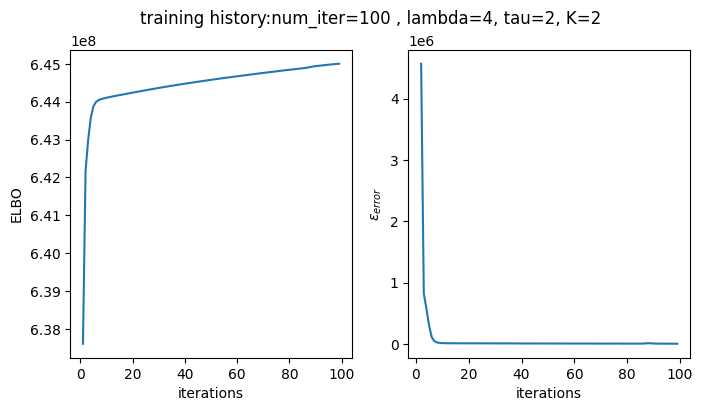

In [ ]:
#@title history
fig,ax=plt.subplots(1,2,figsize=(8,4))
loss=np.array(loss)
error=np.array(error)

ax[0].plot(loss[1:,0],loss[1:,1])
ax[0].set_xlabel('iterations');ax[0].set_ylabel('ELBO')
#ax[0].set_title('loss curve')
ax[1].plot(error[2:,0],error[2:,1])
ax[1].set_xlabel('iterations'); ax[1].set_ylabel('$\\epsilon_{error}$')
plt.suptitle('training history:num_iter=100 , lambda=4, tau=2, K=2')

In [ ]:
#@title Visualization in 2D ( K=2)

# Define the 2D Gaussian function
def gaussian_2d(x, y, mean, cov):
    pos = np.dstack((x, y))
    n = mean.shape[0]
    diff = pos - mean
    inv_cov = np.linalg.inv(cov)
    exponent = np.einsum('...k,kl,...l->...', diff, inv_cov, diff)
    return np.exp(-0.5 * exponent) / np.sqrt((2 * np.pi)**n * np.linalg.det(cov))

# Create grid of points
x = np.linspace(-3, 3, 100)
y = np.linspace(-3, 3, 100)
X, Y = np.meshgrid(x, y)

   # User
def visualization_u(m=0):
    # Parameters for the Gaussian distribution
    mean = mu_u[m]
    cov = Gamma_u[m]  # learned covariance
    C=np.diag(Var_u[m]) # learned variances
    # Calculate the Gaussian distribution values on the grid
    Z = gaussian_2d(X, Y, mean, cov)
    Z_2 = gaussian_2d(X, Y, mean, C)

    plt.figure(figsize=(7, 5))
    # Generate data points for the first distribution based on Z
    data1 = np.column_stack((X.flatten(), Y.flatten(), Z.flatten()))
    data1 = data1[data1[:, 2] > 0]  # Filter out zero densities

    # Generate data points for the second distribution based on Z_2
    data2 = np.column_stack((X.flatten(), Y.flatten(), Z_2.flatten()))
    data2 = data2[data2[:, 2] > 0]  # Filter out zero densities

    # KDE for the first
    sns.kdeplot(x=data1[:, 0], y=data1[:, 1], fill=True, cmap='viridis', alpha=0.6, thresh=0)

    # KDE for the second
    sns.kdeplot(x=data2[:, 0], y=data2[:, 1], fill=True, cmap='Reds', alpha=0.6, thresh=0)

    # Add a legend
    contour1 = plt.Line2D([0], [0], color='green', lw=2, label=f'$u_{m}$ with learned dense $\Gamma_{m}$')
    contour2 = plt.Line2D([0], [0], color='red', lw=2, label=f'$u_{m}$ with learned variances $C_{m}$')
    plt.legend(handles=[contour1, contour2])
    plt.ylim(-4, 4)  # Adjust as needed

    # Labels and title
    plt.title(f'KDE Heatmap of 2D $u_{m}$ , K=2')
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.grid(True)

    plt.show()



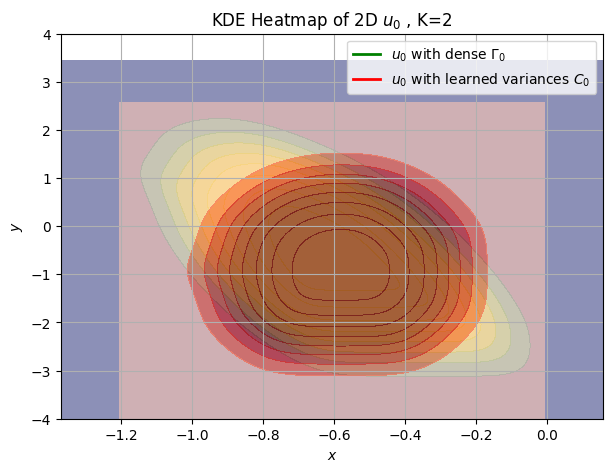

In [ ]:
visualization_u(m=0)

Text(0, 0.5, '$\\epsilon_{error}$')

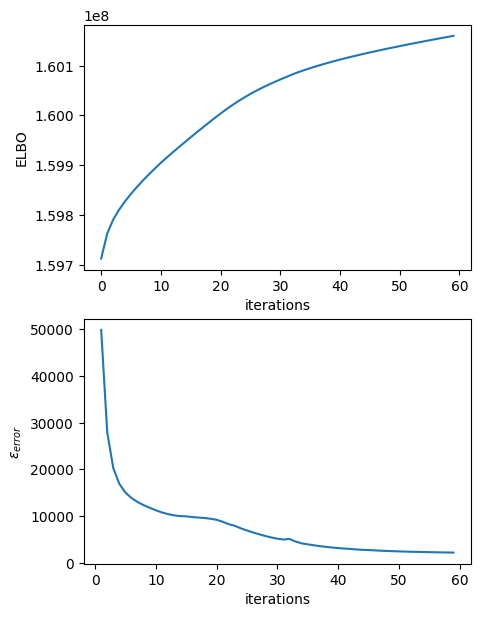

In [ ]:

fig,ax=plt.subplots(1,2,figsize=(7,5))
loss=np.array(loss)
error=np.array(error)

ax[0].plot(loss[:,0],loss[:,1])
ax[0].set_xlabel('iterations');ax[0].set_ylabel('ELBO')
#ax[0].set_title('loss curve')
ax[1].plot(error[:,0],error[:,1])
ax[1].set_xlabel('iterations'); ax[1].set_ylabel('$\\epsilon_{error}$')